In [1]:
import TraceDisplay as TD
from TraceDisplay import BOKEH_RENDERER
import os
from IPython.core.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Loading BokehJS ...

In [2]:
# Chose a .tar
path_to_tar = ! find ../trace -name *.tar | grep -E 'BENCH=kbuild-sched.*GOVERNOR=schedutil.*MONITORING=trace-cmd.*schedlog' | head -n 1
path_to_tar = path_to_tar[0]
path_to_tar

'../trace/HOST=ryzen/BENCH=kbuild-sched/CMDLINE=default/GOVERNOR=schedutil/MONITORING=trace-cmd/16-5.4-schedlog-ftraced/1.tar'

In [3]:
# Get its .h5
path_to_h5 = os.path.splitext(path_to_tar[len('../trace/'):])[0] + '.h5'
path_to_dat = os.path.splitext(path_to_h5)[0] + '.dat'
trace = TD.Trace()
if os.path.exists(path_to_h5):
    trace.load(path_to_h5)
else:
    # Extract .dat and convert to .h5
    ! mkdir -p $(! dirname $path_to_dat)
    path_trace_dat_tgz = ! tar tf $path_to_tar | grep trace.dat.tgz | head -n 1
    path_trace_dat_tgz=path_trace_dat_tgz[0]
    path_trace_dat = ! tar -O -xf $path_to_tar $path_trace_dat_tgz | tar ztf - | grep trace.dat | head -n 1
    path_trace_dat = path_trace_dat[0]
    ! tar -O -xf $path_to_tar $path_trace_dat_tgz | tar -O -xzf - $path_trace_dat > $path_to_dat
    trace.load(path_to_dat)
    trace.save(path_to_h5)
    os.remove(path_to_dat)
trace.keys()

['/sched_wake_idle_without_ipi',
 '/sched_wakeup_new',
 '/sched_waking',
 '/sched_process_wait',
 '/sched_process_exec',
 '/sched_wakeup',
 '/sched_rq_size_change',
 '/sched_process_free',
 '/sched_switch',
 '/sched_process_fork',
 '/sched_tick',
 '/sched_migrate_task',
 '/sched_process_exit',
 '/sched_stat_runtime']

In [4]:
# Shift timestamps
tmin = min([min(trace[k].index) for k in trace])
tmax = max([max(trace[k].index) for k in trace])
print((tmax-tmin)/1e9)
for k in trace:
    trace[k].index = trace[k].index - tmin

7.983065446


In [5]:
"""
Matching Fork/Wait

         Parent
          |         Child
wakeupnew +----------|
          |          |
        .....      .....
          |          |
unblock   +          |       (can be before wakeupnew)
          |          |
wait      +          |       (no wait if parent blocks for another reason)
          |          |
block     +          |       (no block if wakeup happens earlier)
          |          |
          |
          |        .....
          |
          |          |
          |          + exit
          |          |
          |          + wakeup (no wakeup if parent does not block)
          |
unblock   +                   (no unblock if parent does not block)

Should Parent and Child share the same cpu?
Measure intervals where Parent and Child are both ready (TASK_RUNNING)?
"""

def track_fork_wait_wakeup(trace, parent_sched_wakeup_new, **kwargs):
    parent_pid = parent_sched_wakeup_new['common_pid']
    child_pid = parent_sched_wakeup_new['pid']
    #
    # INVARIANT:
    # sched_wakeup_new(common_pid==parent_pid, pid==child_pid) ==>
    # sched_process_exit(common_pid==child_pid)
    #
    # Searching for child_sched_process_exit can fail
    # if it occured after trace-cmd stoped recording
    #
    query_child_sched_process_exit = trace['sched_process_exit'].query('common_pid == %d' % child_pid)
    if len(query_child_sched_process_exit) == 0:
        # TODO: check if it is because we are close to the end of trace.
        return None
    elif len(query_child_sched_process_exit) > 1:
        raise Exception()
    child_sched_process_exit = query_child_sched_process_exit.iloc[0]
    child_sched_process_exit_time = child_sched_process_exit.name
    #
    # INVARIANT:
    # If the parent is blocked on something (TASK_INTERRUPTIBLE),
    # or if it is going to block, the child will try to wake it.
    # But a child can wake up its parent if it's blocked on anything.
    #
    child_sched_wakeup_parent_idx = trace['sched_wakeup'].index.searchsorted(child_sched_process_exit_time)
    query_child_sched_wakeup_parent = trace['sched_wakeup'].iloc[child_sched_wakeup_parent_idx:].query('common_pid == %d & pid == %d' % (child_pid, parent_pid))
    if len(query_child_sched_wakeup_parent) == 0:
        # The child did not wake its parent
        return None
    # The child can try to wakeup its parent multiple times. (I don't know why)
    # Take the last occurence.
    child_sched_wakeup_parent = query_child_sched_wakeup_parent.iloc[-1]
    child_sched_wakeup_parent_time = child_sched_wakeup_parent.name
    #
    # When the child tries to wake up the parent,
    # is it blocked or still running (but wanted to block)? 
    #
    # Get last block and unblock before wakeup and compare their timestamps.
    #
    # TODO: test if prev_state is TASK_INTERRUPTIBLE or TASK_UNINTERRUPTIBLE (not TASK_RUNNING)
    #
    parent_block_before_wakeup_idx = trace['sched_switch'].index.searchsorted(child_sched_wakeup_parent_time)
    query_parent_block_before_wakeup = trace['sched_switch'].iloc[:parent_block_before_wakeup_idx].query('prev_pid == %d' % (parent_pid))
    if len(query_parent_block_before_wakeup) == 0:
        parent_block_before_wakeup = None
        parent_block_before_wakeup_time = 0
    else:
        parent_block_before_wakeup = query_parent_block_before_wakeup.iloc[-1]
        parent_block_before_wakeup_time = parent_block_before_wakeup.name
    # Do same for unblock
    parent_unblock_before_wakeup_idx = trace['sched_switch'].index.searchsorted(child_sched_wakeup_parent_time)
    query_parent_unblock_before_wakeup = trace['sched_switch'].iloc[:parent_unblock_before_wakeup_idx].query('next_pid == %d' % (parent_pid))
    if len(query_parent_unblock_before_wakeup) == 0:
        # parent_unblock_before_wakeup = None
        # parent_unblock_before_wakeup_time = 0
        # TODO: check if it is because we are close to the start of trace.
        return None
    else:
        parent_unblock_before_wakeup = query_parent_unblock_before_wakeup.iloc[-1]
        parent_unblock_before_wakeup_time = parent_unblock_before_wakeup.name        
    if parent_unblock_before_wakeup_time > parent_block_before_wakeup_time:
        # The parent was running
        return None
    #
    # Did the parent block because it was waiting for its child?
    # Is there a sched_process_wait between:
    #
    # parent_unblock_before_wakeup
    #           ???
    # parent_block_before_wakeup
    #
    parent_sched_process_wait_idx_min = trace['sched_process_wait'].index.searchsorted(parent_unblock_before_wakeup_time)
    parent_sched_process_wait_idx_max = trace['sched_process_wait'].index.searchsorted(parent_block_before_wakeup_time)
    query_parent_sched_process_wait = trace['sched_process_wait'].iloc[parent_sched_process_wait_idx_min:parent_sched_process_wait_idx_max].query('common_pid == %d' % (parent_pid))
    if len(query_parent_sched_process_wait) == 0:
        # The parent did not call wait,
        # it blocked for another reason.
        return None
    parent_sched_process_wait = query_parent_sched_process_wait.iloc[-1]
    return {
        'parent_sched_wakeup_new'      : parent_sched_wakeup_new,
        'child_sched_process_exit'     : child_sched_process_exit,
        'child_sched_wakeup_parent'    : child_sched_wakeup_parent,
        'parent_unblock_before_wakeup' : parent_unblock_before_wakeup,
        'parent_block_before_wakeup'   : parent_block_before_wakeup,
        'parent_sched_process_wait'    : parent_sched_process_wait,
    }

In [6]:
# %%time
def compute_results(trace):
    results = {}
    total = 0
    n = len(trace['sched_wakeup_new'])
    print('n=%d'%n)
    for i in range(n):
        parent_sched_wakeup_new = trace['sched_wakeup_new'].iloc[i]
        pattern = track_fork_wait_wakeup(trace, parent_sched_wakeup_new, i=i)
        if pattern:
            total += 1
            for k,v in pattern.items():
                results.setdefault(k,[]).append(v)
    print('total=%d'%total)
    results = {k:pd.DataFrame(v) for k,v in results.items()}
    for k,v in results.items():
        v['i'] = np.arange(total)
        v.index.name = 'timestamp'
    return results
# results = TD.DataFrameCollection()
results = TD.Trace()
if os.path.exists('results.h5'):
    results.load('results.h5')
else:
    results.df = compute_results(trace)
    results.save('results.h5')

In [7]:
# for k,v in results.items():
#     print(k)
#     display(v)

In [8]:
def shape(key, df):
    def func(df):
        df = df[key]
        timestamp = np.array(df.index, dtype=float)
        cpu = np.array(df['cpu'], dtype=float)
        i = np.array(df['i'], dtype=int)
        pid = np.array(df['common_pid'], dtype=int)
        return {
            'x0' : timestamp,
            'x1' : timestamp,
            'y0' : cpu,
            'y1' : cpu + 0.5,
            'i'  : i,
            'pid' : pid,
        }
    return (key, func)
shapes = [shape(k, results) for k in results]

In [9]:
image = TD.Image()
image.build(results, shapes)
ci = TD.ColoredImage(image)
HTML(ci.html_legend())

In [10]:
def callback(xmin, xmax, ymin, ymax):
    display(results.timeline((xmax+xmin)*.5, tmin=xmin, tmax=xmax))
    display(trace.timeline((xmax+xmin)*.5, tmin=xmin, tmax=xmax))
br = TD.BokehRenderer()
br.notify_update.append(callback)
br.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJ1dHRvbihkZXNjcmlwdGlvbj11J1J1biBJbnRlcmFjdCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz0odSd3aWTigKY=


(3502812.0, 7982909996.0)
(0, 7.5)


,common_comm,common_flags,common_pid,common_preempt_count,cpu,event,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state,i,comm,pid,prio,success,target_cpu
timestamp,,,,,,,,,,,,,,,,,,,
3947137339,<idle>,1,0,2,0,sched_switch,make,5599.0,120.0,swapper/0,0.0,120.0,R,2356,NaN,NaN,NaN,NaN,NaN
3947149199,<...>,0,5599,0,0,sched_process_wait,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2356,make,0.0,120.0,NaN,NaN
3947151289,<...>,1,5599,2,0,sched_switch,swapper/0,0.0,120.0,make,5599.0,120.0,S,2356,NaN,NaN,NaN,NaN,NaN
3954223803,<...>,1,5633,2,1,sched_wakeup_new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2357,sh,5634.0,120.0,1.0,6.0
3954326413,<...>,0,5633,0,1,sched_process_wait,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2357,sh,0.0,120.0,NaN,NaN
3954340393,<...>,1,5633,2,1,sched_switch,swapper/1,0.0,120.0,sh,5633.0,120.0,S,2357,NaN,NaN,NaN,NaN,NaN
3957446275,<...>,1,5634,2,6,sched_wakeup_new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2358,gcc,5635.0,120.0,1.0,7.0
3957699375,<idle>,1,0,2,6,sched_switch,gcc,5634.0,120.0,swapper/6,0.0,120.0,R,2358,NaN,NaN,NaN,NaN,NaN
3957721145,<...>,0,5634,0,6,sched_process_wait,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2358,gcc,5635.0,120.0,NaN,NaN


,common_comm,common_flags,common_pid,common_preempt_count,cpu,event,comm,pid,prio,success,...,runtime,vruntime,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state,freq
timestamp,,,,,,,,,,,,,,,,,,,,,
3984242609,ksoftirqd/3,16,35,0,3,sched_process_free,mkdir,5630.0,120.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984247289,ksoftirqd/3,16,35,0,3,sched_process_free,sed,5631.0,120.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984252259,ksoftirqd/3,16,35,0,3,sched_process_free,mv,5632.0,120.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984259919,ksoftirqd/3,1,35,2,3,sched_stat_runtime,ksoftirqd/3,35.0,NaN,NaN,...,36200.0,1.742080e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984261249,ksoftirqd/3,1,35,2,3,sched_rq_size_change,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984263239,ksoftirqd/3,1,35,2,3,sched_switch,NaN,NaN,NaN,NaN,...,NaN,NaN,swapper/3,0.0,120.0,ksoftirqd/3,35.0,120.0,S,NaN
3987537401,<...>,9,5635,1,7,sched_stat_runtime,cc1,5635.0,NaN,NaN,...,3316282.0,8.181981e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3987542251,<...>,9,5635,1,7,sched_tick,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1256647.0
3990871153,<...>,9,5635,1,7,sched_stat_runtime,cc1,5635.0,NaN,NaN,...,3318812.0,8.185300e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


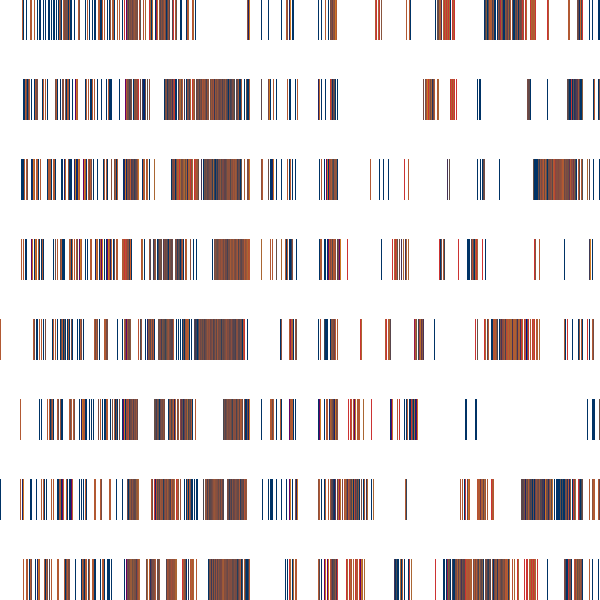

In [11]:
br.render(ci)
display(br.image)